In [1]:
import sys
sys.path.append("..")
import argparse
import numpy as np
import dgl
from dgl import DGLGraph
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import pickle
import h5py
import random
import glob2
import seaborn as sns

import train
import models

%load_ext autoreload
%autoreload 2

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = train.get_device()

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
category = "real_data"

epochs = 10

pca_size = 50
path = "../"
files = glob2.glob(f'{path}real_data/*.h5')
files = [f[len(f"'{path}real_data"):-3] for f in files]
print(files)
files = [
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Trachea',
    'Muraro',
    
    
    'worm_neuron_cell',
    'mouse_ES_cell',
    
    'Young',
    'Adam',
    'Quake_10x_Bladder',
    'Quake_Smart-seq2_Lung',
    'Quake_10x_Limb_Muscle',
    
    'mouse_bladder_cell',
    'Romanov',
    'Quake_Smart-seq2_Limb_Muscle',
    
    '10X_PBMC',
    
    'Quake_Smart-seq2_Diaphragm',
    
    
]

['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']


In [ ]:
results = pd.DataFrame()
model_name = "GraphConv"
normalize_weights = "log_per_cell"
node_features = "scale"
same_edge_values = False
edge_norm = True
hidden_relu = False
hidden_bn = False
n_layers = 2

hidden_dim = 200
hidden = [300]
nb_genes = 3000
activation = F.relu
for dataset in files:
    print(f">> {dataset}")

    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")
    if "gene_names" not in data_mat.keys():
        continue
    for factor in [100, 200, 500]: # limit the nb of introduced correlations
        w=1
        gene_names = data_mat["gene_names"][()]
        Y = np.array(data_mat['Y'])
        X = np.array(data_mat['X'])
        batch_size = 64 if X.shape[0] <5000 else 25
        t0 = time.time()
        genes_idx, cells_idx = train.filter_data(X, highly_genes=nb_genes)
        X = X[cells_idx][:, genes_idx]
        Y = Y[cells_idx]
        gene_names = gene_names[genes_idx]
        max_size = X.shape[0] * X.shape[1]//factor
        gene_data = train.tissue_data(
            gene_names,
            filename="../../gene_network/41598_2017_4520_MOESM2_ESM.pkl",
            threshold=0.5,
            plot=False,
            method='pearson',
            max_size = max_size)

        gene_data["single_layer"] = False
        gene_data["weight"] = w


        graph = train.make_graph(
            X,
            Y,
            dense_dim=pca_size,
            node_features=node_features,
            normalize_weights=normalize_weights,
            threshold = 0,
            gene_data = gene_data
        )

        labels = graph.ndata["label"]
        train_ids = np.where(labels != -1)[0]

        sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)

        dataloader = dgl.dataloading.NodeDataLoader(
            graph,
            train_ids,# np.arange(len(labels)), #
            sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=1,
        )
        print(
            f"INPUT: {factor}, {w}, {model_name}  {hidden_dim}, {hidden}, {same_edge_values}, {edge_norm}"
        )
        t1 = time.time()

        for run in range(3):
            t_start = time.time()
            torch.manual_seed(run)
            torch.cuda.manual_seed_all(run)
            np.random.seed(run)
            random.seed(run)

            model = models.GCNAE(
                in_feats=pca_size,
                n_hidden=hidden_dim,
                n_layers=n_layers,
                activation=activation,
                dropout=0.1,
                hidden=hidden,
                hidden_relu=hidden_relu,
                hidden_bn=hidden_bn,
            ).to(device)
            if run == 0:
                print(f">", model)

            optim = torch.optim.Adam(model.parameters(), lr=1e-5)
            model = train.train(model, optim, epochs, dataloader, plot=False,
                                cluster=["KMeans", "Leiden"])

            dataloader = dgl.dataloading.NodeDataLoader(
                graph,
                train_ids,
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=1,
            )
            scores = train.evaluate(model, dataloader, save=True, cluster=["KMeans", "Leiden"], use_cpu = False)

            print(f'ARI {scores.get("kmeans_ari")}, {scores.get("kmeans_sil")}')


            scores["dataset"] = dataset
            scores["run"] = run
            scores["nb_genes"] = nb_genes
            scores["hidden"] = str(hidden)
            scores["hidden_dim"] = str(hidden_dim)
            scores["tot_kmeans_time"] = (t1-t0) + (scores['ae_end'] - t_start) + scores['kmeans_time']
            scores["tot_leiden_time"] = (t1-t0) + (scores['ae_end'] - t_start) + scores['leiden_time']
            scores["time_graph"] = t1-t0
            scores["time_training"] = (scores['ae_end'] - t_start)
            scores["factor"] = factor
            scores["w"] = w

            results = results.append(scores, ignore_index = True)

            results.to_pickle(
                f"../output/pickle_results/{category}/{category}_gae_tissue.pkl")
            print("Done")

results.mean()  

# Create plots

In [3]:
category = "real_data"
results = pd.read_pickle(
                f"../output/pickle_results/{category}/{category}_gae_tissue.pkl")
results = results[~results["dataset"].isin(["Muraro", "Adam"])] # Exclude human datasets
# results.groupby(["dataset", "factor"] )["kmeans_ari"].mean().unstack("factor")

In [4]:
v = results.groupby(["dataset", "factor"] )["kmeans_ari"].mean().unstack("factor")
v["best"] =v.values.argmax(axis = 1)
v = v.reset_index()
v["sel"] = v.apply(lambda x: f"{x['dataset']}_{[100, 200, 500][x['best']]}", axis = 1)
v

factor,dataset,100.0,200.0,500.0,best,sel
0,Quake_10x_Bladder,0.962867,0.964733,0.968100,2,Quake_10x_Bladder_500
1,Quake_10x_Limb_Muscle,0.952333,0.960633,0.967667,2,Quake_10x_Limb_Muscle_500
2,Quake_10x_Spleen,0.886700,0.846300,0.435167,0,Quake_10x_Spleen_100
3,Quake_Smart-seq2_Diaphragm,0.946233,0.945167,0.947567,2,Quake_Smart-seq2_Diaphragm_500
4,Quake_Smart-seq2_Limb_Muscle,0.925733,0.918067,0.926800,2,Quake_Smart-seq2_Limb_Muscle_500
5,Quake_Smart-seq2_Lung,0.785367,0.737600,0.777000,0,Quake_Smart-seq2_Lung_100
6,Quake_Smart-seq2_Trachea,0.775333,0.786267,0.802733,2,Quake_Smart-seq2_Trachea_500
7,Romanov,0.692500,0.746800,0.760467,2,Romanov_500
8,Young,0.491067,0.539267,0.652200,2,Young_500


In [5]:
results["sel"] = results.apply(lambda x: f"{x['dataset']}_{int(x['factor'])}", axis = 1)
result1 = results[results["sel"].isin(v["sel"].values)]
result1["Type"] = "with external data"
result1 = result1[["dataset", "run" , "kmeans_ari", "Type"]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# get baseline model as results
results = pd.read_pickle(
    f"../output/pickle_results/{category}/{category}_gae.pkl")

results = results[results["dataset"].isin(result1.dataset.values)]

results = results[["dataset", "run" , "kmeans_ari", ]]
results["Type"] = "baseline"
# Merge baseline with external data results
m = pd.concat([results, result1])

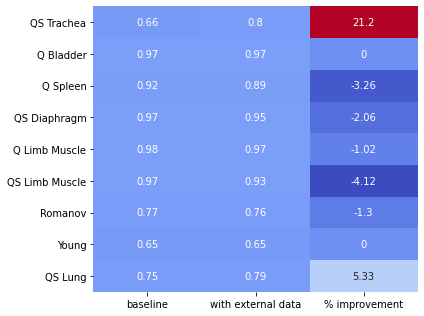

In [37]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES Cell',
    'mouse_ES_cell_select_2100': 'Mouse ES Cell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron Cell (2100)',
    'worm_neuron_cell': 'Worm Neuron Cell',
    'mouse_bladder_cell': 'Mouse Bladder Cell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder  Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
}

m["dataset_label"] = m["dataset"].apply(
    lambda x: dataset_names.get(x, x))

datasets = [
    'Quake_Smart-seq2_Trachea',
    'Quake_10x_Bladder',
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Diaphragm',
    'Quake_10x_Limb_Muscle',
    'Quake_Smart-seq2_Limb_Muscle',
    'Romanov',
    'Adam',
    'Muraro',
    'Young',
    'Quake_Smart-seq2_Lung',
    '10X_PBMC',
    'mouse_ES_cell',
    'worm_neuron_cell',
    'mouse_bladder_cell',
]

ordered_datasets = dict(zip(datasets, np.arange(len(datasets))))

m["ordered_dataset"] = m["dataset"].apply(lambda x: ordered_datasets[x])

res = m.groupby(["dataset_label", "Type"])[["kmeans_ari", "ordered_dataset"]].mean().unstack("Type").round(2)
res

res.columns = ["baseline", "with external data", "a", "b"]

res

res = res.sort_values(by=["a"]).drop(["a", "b"], axis = 1)

res

plt.figure(figsize = (6, 4.5))
ax = plt.subplot(111)


res["% improvement"] = 100 *(res["with external data"] - res["baseline"])/res["baseline"].round(2)
res["% improvement"] = res["% improvement"].round(2)
sns.heatmap(res, annot=True, cmap="coolwarm", fmt='.3g', ax=ax, cbar=False)
plt.ylabel("");
plt.tight_layout()
plt.savefig(f"../diagrams/external_results.svg", bbox_inches='tight')